### Fase 2 FIAP - Desafio 1 

Previsão de preços de veículos

#### Importando as bibliotecas

In [67]:
# tratamentos de dados
import pandas as pd
import numpy as np

# dataviz
import matplotlib.pyplot as plt
import seaborn as sns

# processamento de dados & ML
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR

# avaliacao dos modelos
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

#### carregando o dataset

In [42]:
dados = pd.read_csv(r'https://raw.githubusercontent.com/FIAP/Pos_Tech_DTAT/61a634996879d5c1384af6f567e29659ad68b727/Desafio/cars.csv')

In [43]:
dados.head(3)

,id,brand,model,year,miles,city_mileage,highway_mileage,horsepower,torque,engine_capacity_litre,...,type,doors,wheel_drive,engine_type,speed_levels,front_headroom,front_legroom,rear_headroom,rear_legroom,service_records
0,3,Chevrolet,Volt LT,2019,27173,43,42,149,294,1.5,...,sedan,4,2,hybrid_gas_electric,6.0,37.8,42.1,35.8,34.7,4
1,6,Hyundai,Elantra SE,2017,76941,29,38,146,132,2.0,...,sedan,4,2,gas,6.0,39.0,42.2,37.0,35.7,16
2,7,Ford,Focus,2014,97027,27,37,159,146,2.0,...,sedan,4,2,gas,6.0,38.3,43.7,38.0,33.2,13


#### tratamento do dataset

analisando o tamanho do dataset

In [44]:
print(f'Número de linhas: {dados.shape[0]}')
print(f'Número de colunas: {dados.shape[1]}')

Número de linhas: 52
Número de colunas: 27


In [45]:
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     52 non-null     int64  
 1   brand                  52 non-null     object 
 2   model                  52 non-null     object 
 3   year                   52 non-null     int64  
 4   miles                  52 non-null     int64  
 5   city_mileage           52 non-null     int64  
 6   highway_mileage        52 non-null     int64  
 7   horsepower             52 non-null     int64  
 8   torque                 52 non-null     int64  
 9   engine_capacity_litre  52 non-null     float64
 10  fuel_capacity          52 non-null     float64
 11  num_cylinder           52 non-null     int64  
 12  num_seat               52 non-null     int64  
 13  num_owners             52 non-null     int64  
 14  price                  52 non-null     int64  
 15  link    

analisando valores faltantes

In [46]:
dados.isnull().sum()

id                        0
brand                     0
model                     0
year                      0
miles                     0
city_mileage              0
highway_mileage           0
horsepower                0
torque                    0
engine_capacity_litre     0
fuel_capacity             0
num_cylinder              0
num_seat                  0
num_owners                0
price                     0
link                      0
condition                51
type                      0
doors                     0
wheel_drive               0
engine_type               0
speed_levels              1
front_headroom            0
front_legroom             0
rear_headroom             0
rear_legroom              0
service_records           0
dtype: int64

removendo valores faltantes

In [47]:
dados.drop(columns=['condition'], inplace=True)

In [48]:
dados.dropna(axis=0, inplace=True)

In [49]:
dados.isnull().sum().sum()

0

In [50]:
dados.duplicated().sum()

0

#### EDA

In [51]:
# as colunas de object podem ter informaçoes relevantes que podem impactar no preço, exemplo 'marca'
print('Colunas object: ')
for coluna in dados.columns:
    if dados[coluna].apply(lambda x: isinstance(x, str)).all():
        print(coluna)

print('-'*30)

print('Colunas de valor:')
for coluna in dados.columns:
    if dados[coluna].apply(lambda x: isinstance(x, (int, float))).all():
        print(coluna)

Colunas object: 
brand
model
link
type
engine_type
------------------------------
Colunas de valor:
id
year
miles
city_mileage
highway_mileage
horsepower
torque
engine_capacity_litre
fuel_capacity
num_cylinder
num_seat
num_owners
price
doors
wheel_drive
speed_levels
front_headroom
front_legroom
rear_headroom
rear_legroom
service_records


Vou analisar a correlação entre as variáveis numéricas e posteriormente avaliar se as variáveis categoricas podem ter relação com preço

In [52]:
dados.describe().T

,count,mean,std,min,25%,50%,75%,max
id,51.0,31.725490,15.308923,3.0,19.50,32.0,44.5,57.0
year,51.0,2018.686275,1.406985,2014.0,2018.00,2019.0,2019.5,2022.0
miles,51.0,33984.137255,22918.580263,5000.0,16328.50,27440.0,43085.0,97027.0
city_mileage,51.0,28.745098,5.613709,17.0,26.00,30.0,30.0,55.0
highway_mileage,51.0,37.372549,4.161542,24.0,35.50,38.0,40.0,49.0
horsepower,51.0,176.176471,33.758973,143.0,152.00,159.0,192.0,288.0
torque,51.0,179.470588,46.376871,99.0,138.00,184.0,192.0,294.0
engine_capacity_litre,51.0,1.839216,0.380567,1.4,1.50,2.0,2.0,3.5
fuel_capacity,51.0,14.374510,2.418582,8.9,12.40,14.0,15.3,19.0
num_cylinder,51.0,4.039216,0.280056,4.0,4.00,4.0,4.0,6.0


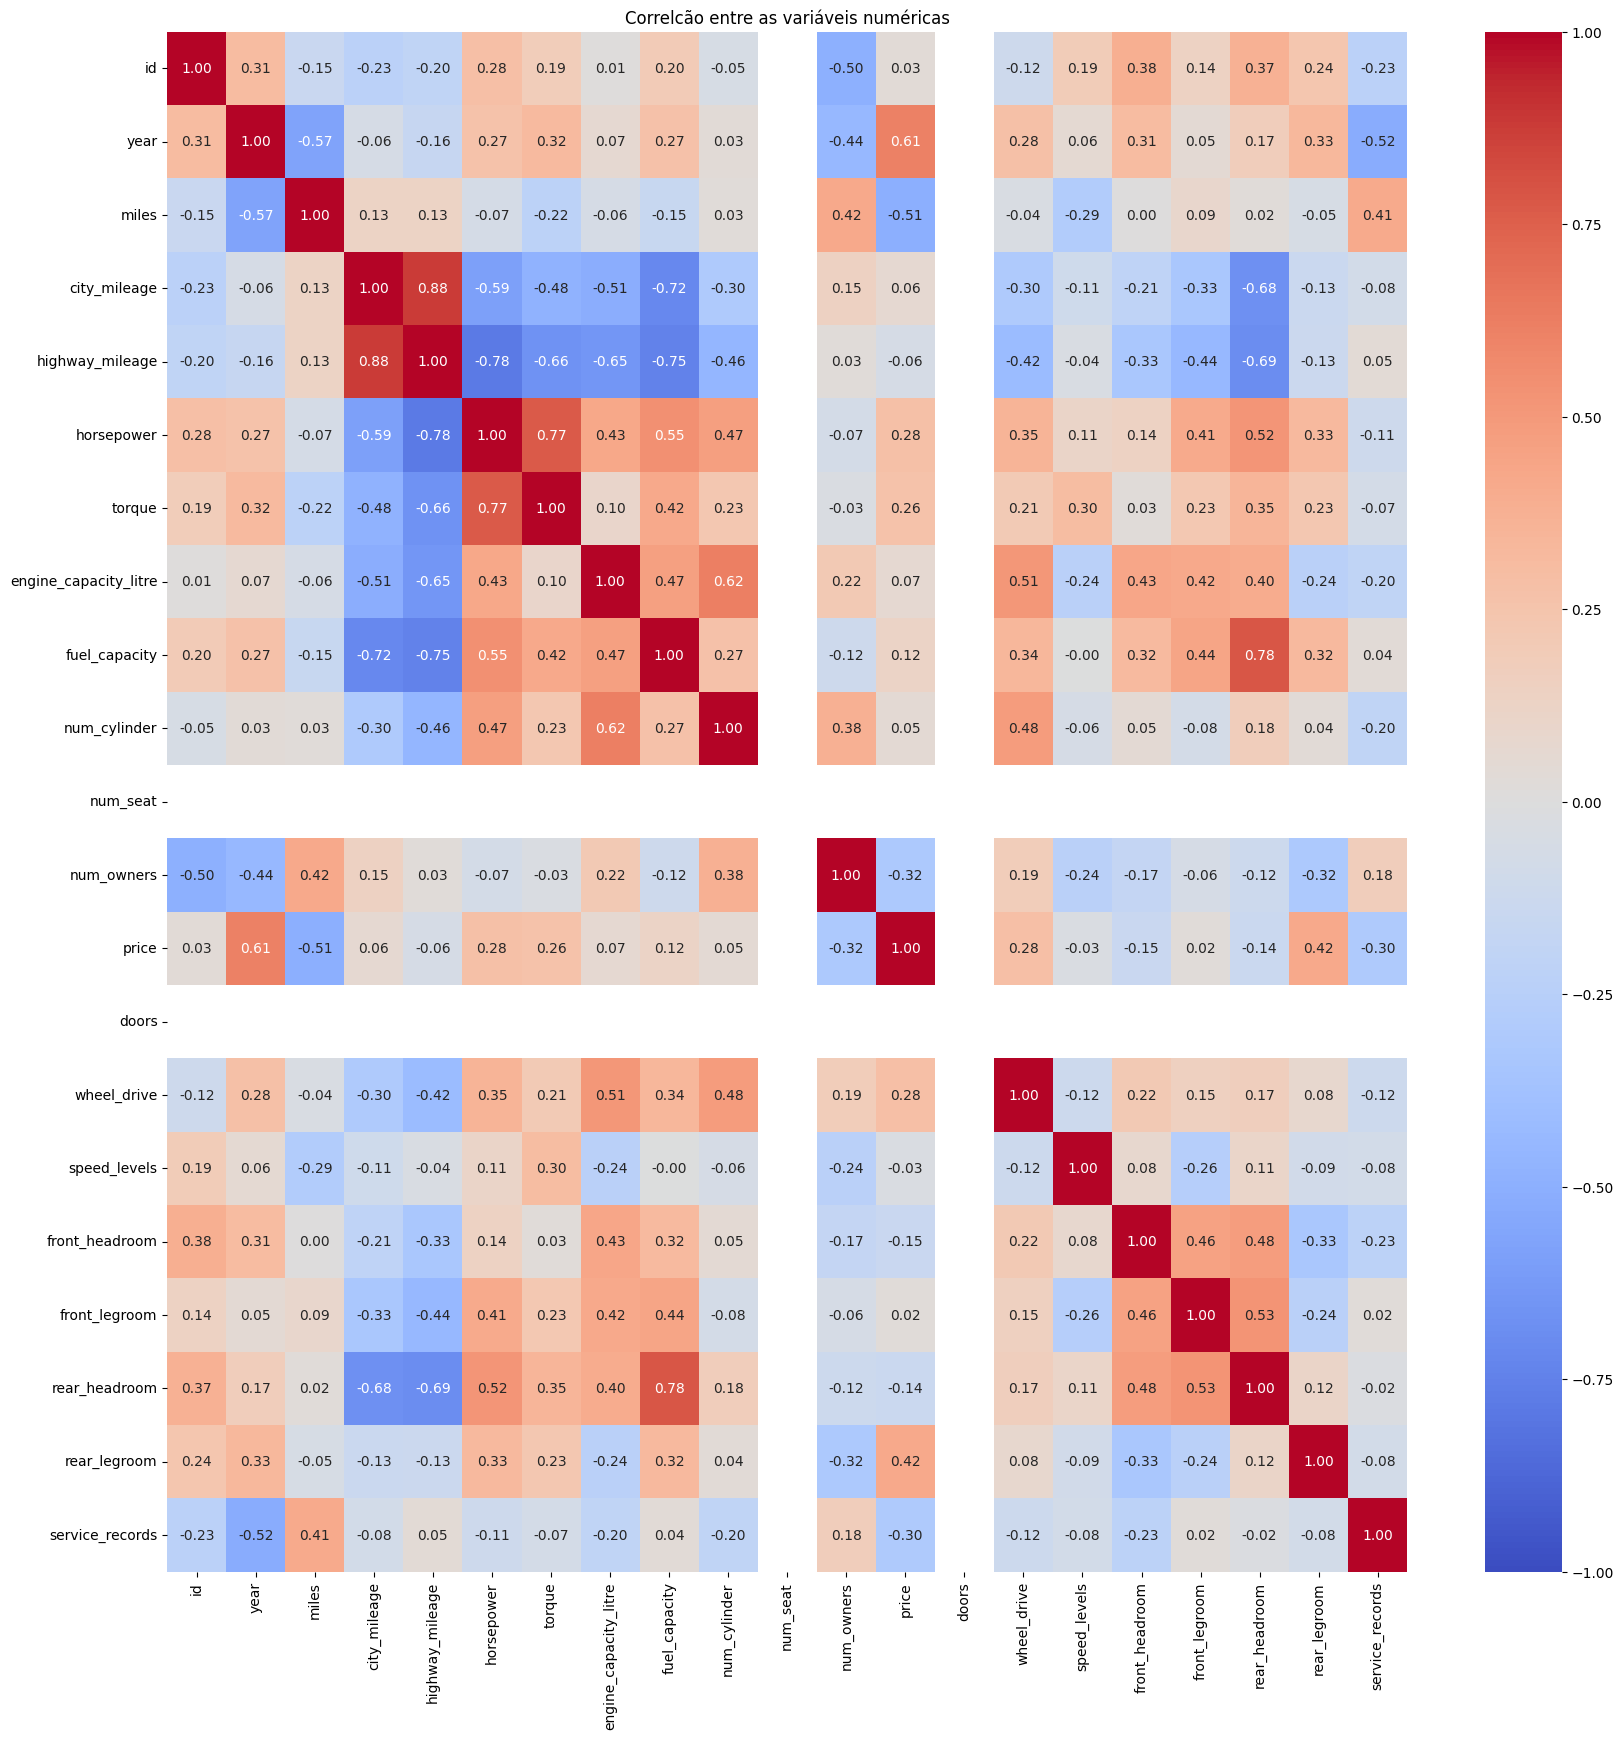

In [53]:
dados_numeric = dados.select_dtypes(include='number')

corr_matrix = dados_numeric.corr()

plt.figure(figsize=(20, 20))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, fmt='.2f')

plt.title('Correlcão entre as variáveis numéricas')
plt.show()

as variáveis com maior correlação com preços são: rear_legroom, horse power, torque e year 

In [54]:
# selecionando colunas, selecionar as numéricas que ja identifiquei correlação e as colunas object que ainda não avaliar
dados = dados[['brand', 'model', 'link', 'type', 'engine_type', 'rear_legroom', 'horsepower', 'torque', 'year', 'price']]

In [55]:
def plot_scater(df, x_axis, y_axis):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.scatterplot(x=df[x_axis], y=df[y_axis], color='blue')
    plt.title(f'Relação entre {x_axis} e {y_axis}')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.grid(True)
    plt.show()

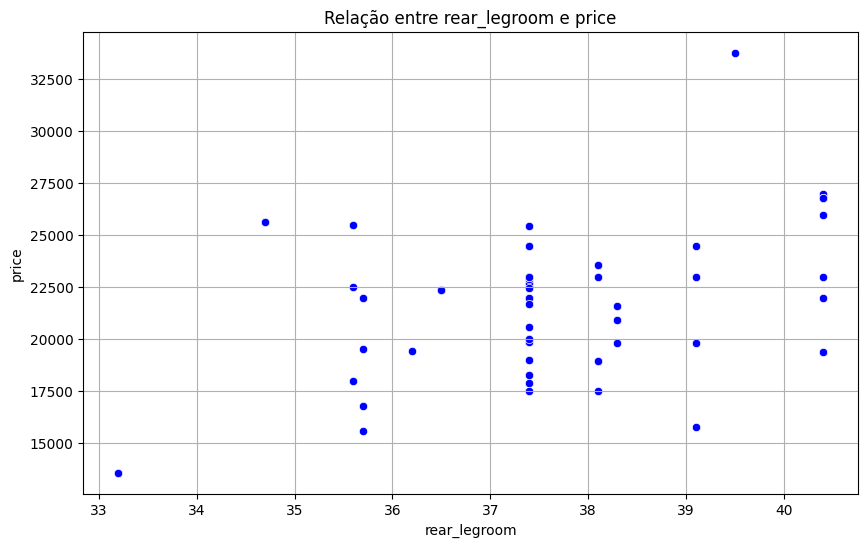

In [56]:
plot_scater(dados, 'rear_legroom', 'price')

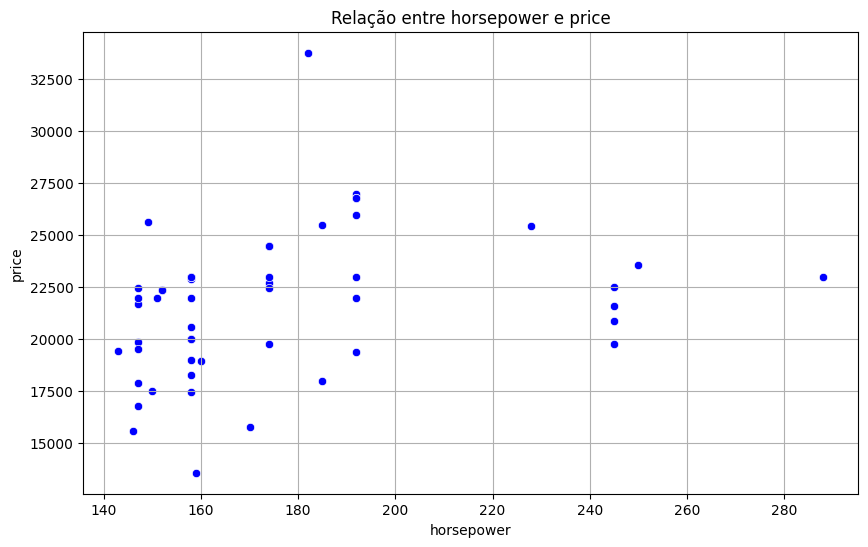

In [57]:
plot_scater(dados, 'horsepower', 'price')

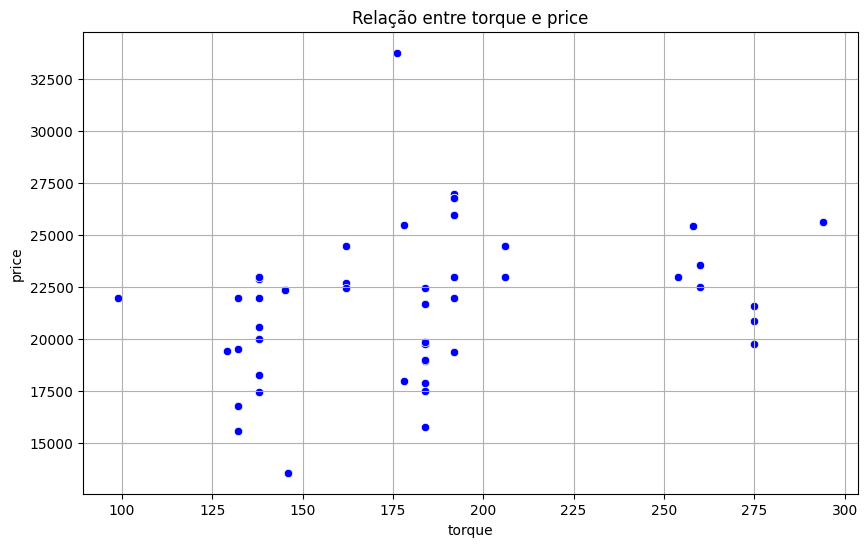

In [58]:
plot_scater(dados, 'torque', 'price')

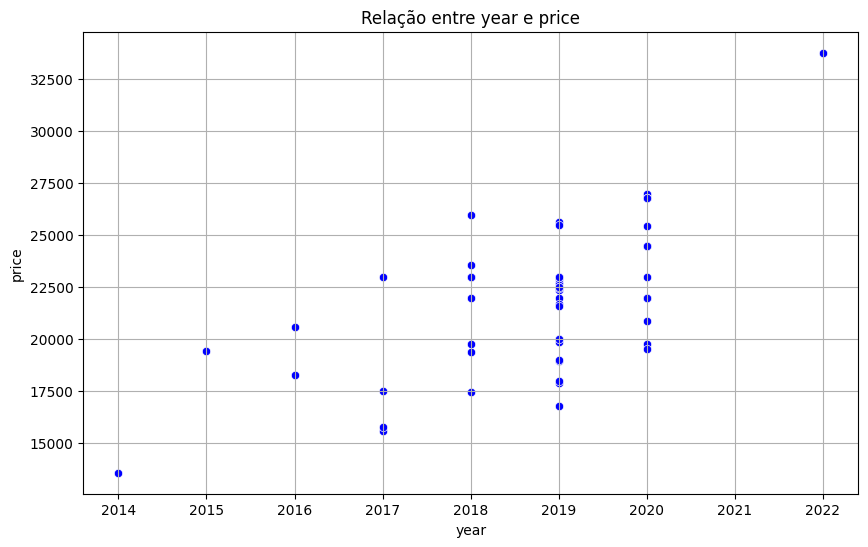

In [59]:
plot_scater(dados, 'year', 'price')

analisando outliers

In [15]:
# definindo funçao de plot violin + boxplot para analisar distribuiçao e outliers
def plot_boxplot(df, x_axis):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.boxplot(data=df, x=x_axis, ax=ax, color='darkblue')
    sns.violinplot(data=df, x=x_axis, ax=ax, color='lightgray')
    ax.set_title('Visualização BoxPlot e Violin Plot')

    plt.show()

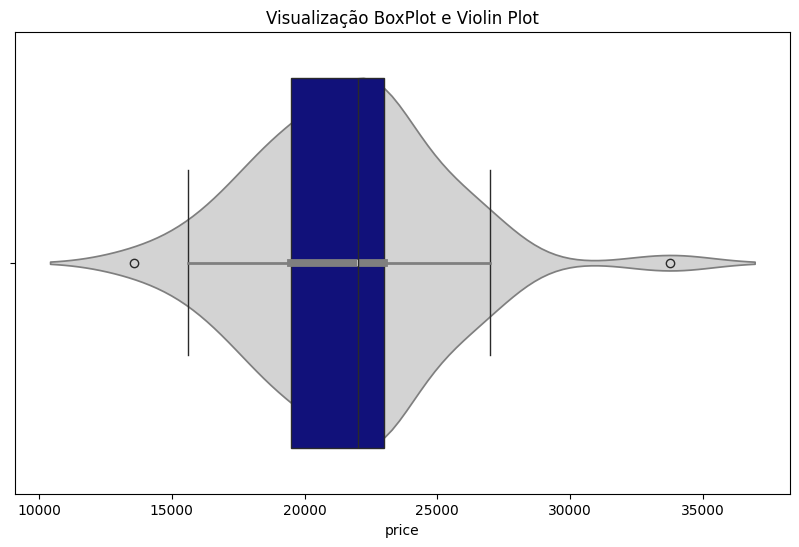

In [16]:
plot_boxplot(dados, 'price')

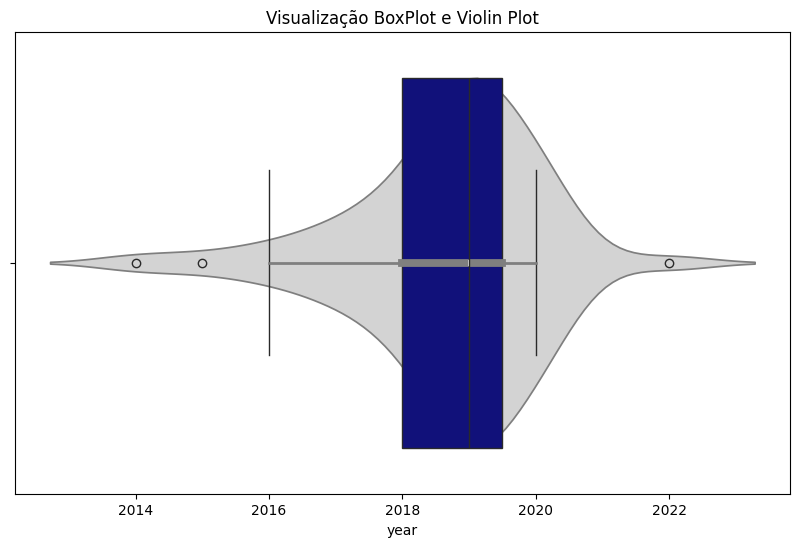

In [17]:
plot_boxplot(dados, 'year')

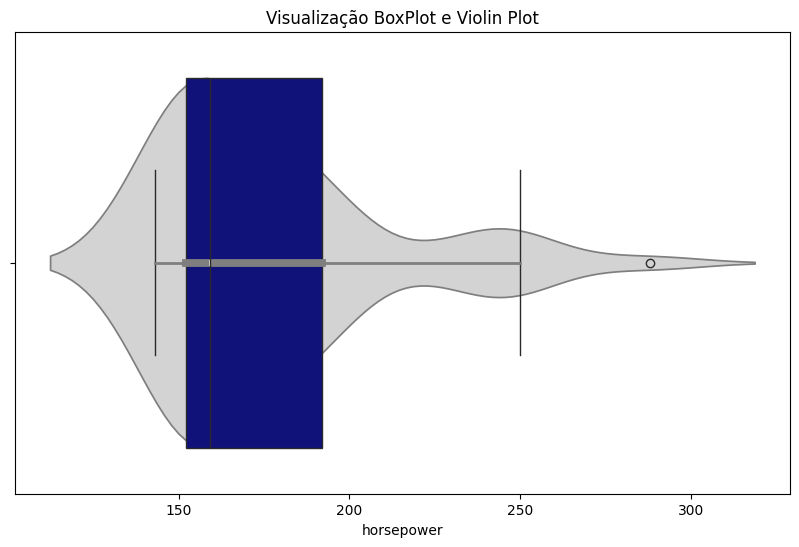

In [18]:
plot_boxplot(dados, 'horsepower')

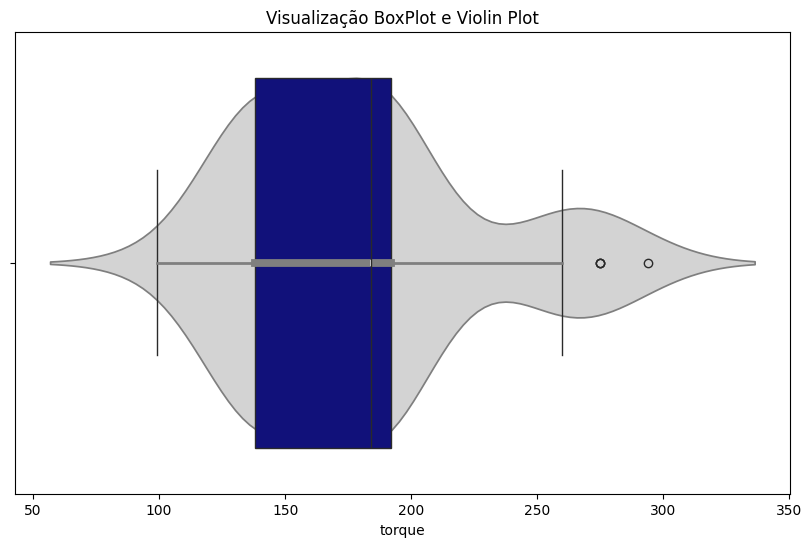

In [19]:
plot_boxplot(dados, 'torque')

Não temos um número grande de outlies, temos um modelo com preço acima do limite que pode ser um veículo esportivo, lançamento e com grande potência.

Portanto não irei remover outliers

Analisando as variáveis categórias vs preço

In [20]:
# definindo função para deixar mais ágil o processo de plot das variáveis categoricas
def plot_bar(df, x_axis, y_axis):
    plt.figure(figsize=(10, 5))

    bars = plt.bar(df[x_axis], df[y_axis])
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.yticks([])

    plt.bar_label(bars, fmt='{:,.0f}')
    [spine.set_visible(False) for spine in plt.gca().spines.values()]

    plt.tight_layout()
    plt.show()

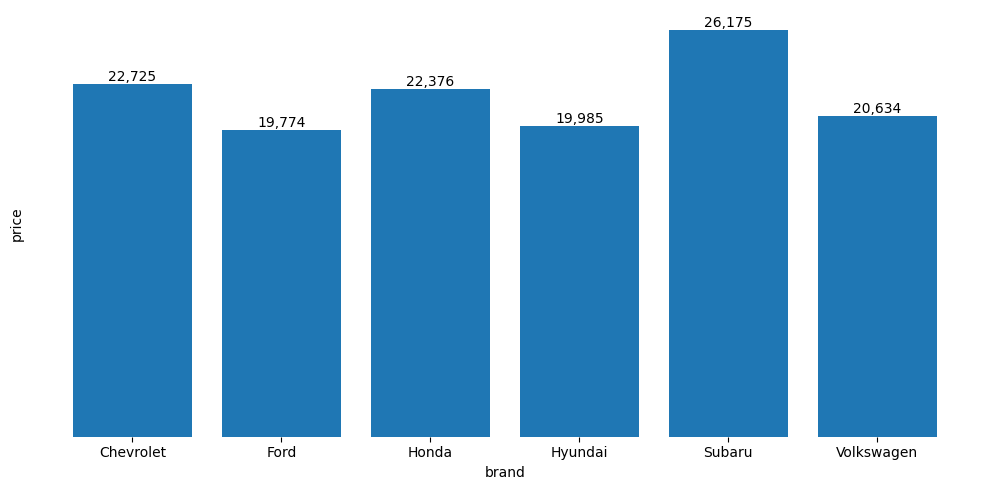

In [21]:
preco_medio_brand = dados.groupby('brand')['price'].mean().reset_index()
plot_bar(preco_medio_brand, 'brand', 'price')

É importante manter a marca como no dataset porque existe diferença visualmente significativa para cada marca

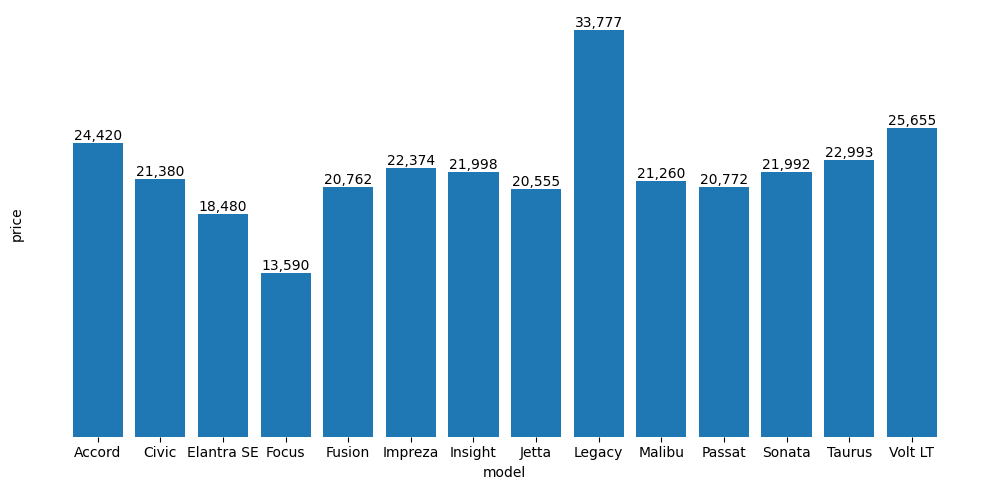

In [22]:
preco_medio_model = dados.groupby('model')['price'].mean().reset_index()
plot_bar(preco_medio_model, 'model', 'price')

É necessário manter coluna de modelo, porque existe diferença visualmente significativa entre modelos. Porém um novo modelo o algoritmo poderia se perder, então vou manter apenas a marca

In [23]:
dados.drop('model', axis=1, inplace=True)

C:\Users\Igor\AppData\Local\Temp\ipykernel_10336\775975445.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations.
  plt.tight_layout()


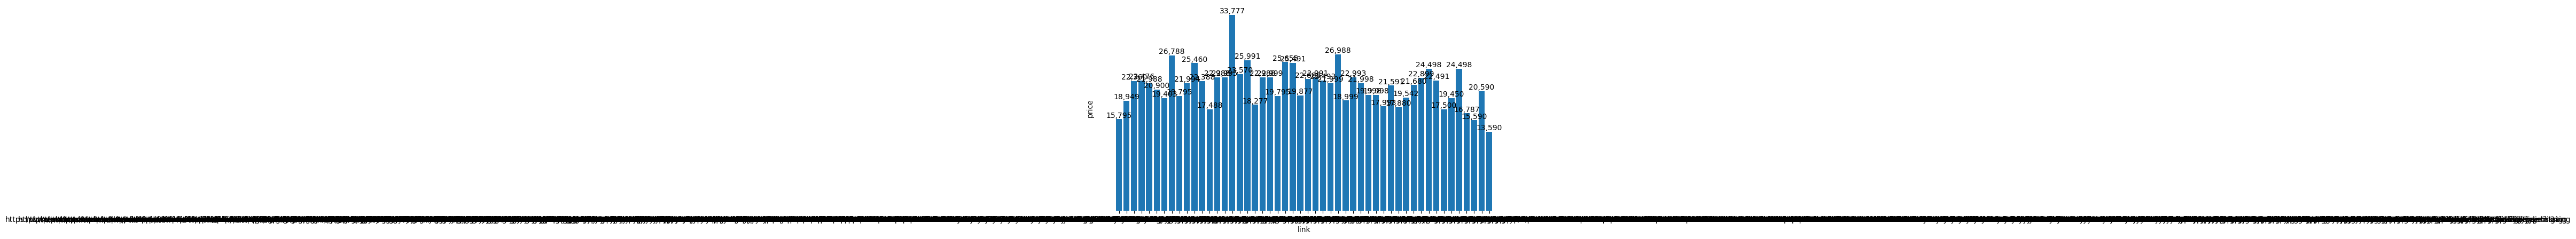

In [24]:
preco_medio_link = dados.groupby('link')['price'].mean().reset_index()
plot_bar(preco_medio_link, 'link', 'price')

Não é necessário manter coluna link, pois se trata do url do anúncio do veículo

In [25]:
dados.drop('link', axis=1, inplace=True)

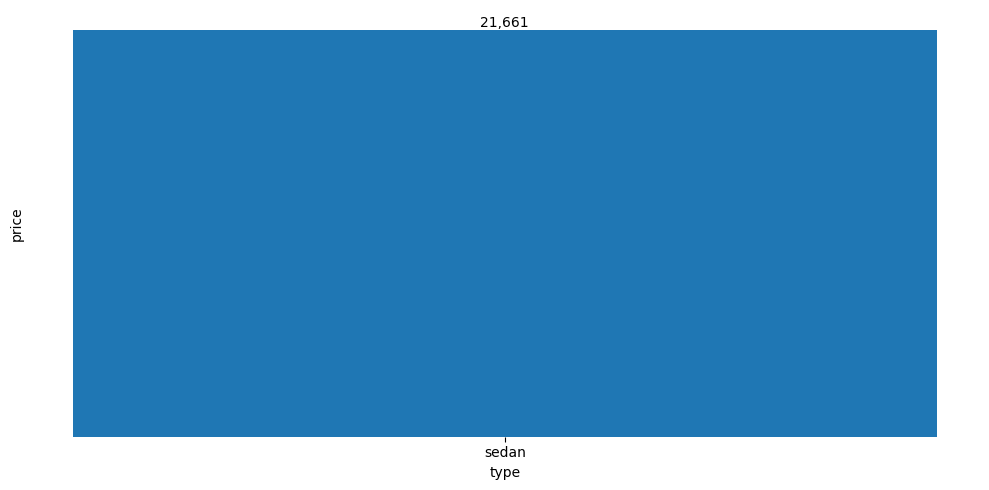

In [26]:
preco_medio_type = dados.groupby('type')['price'].mean().reset_index()
plot_bar(preco_medio_type, 'type', 'price')

Só existe um tipo de veículo, portanto nesse momento não é necessario manter essa coluna. Porém é importante avaliar no futuro quando houver novos tipos de veiculos se é necessário olhar para essa feature, pois um modelo SUV pode ter preço muito diferente de um sedan

In [27]:
dados.drop('type', axis=1, inplace=True)

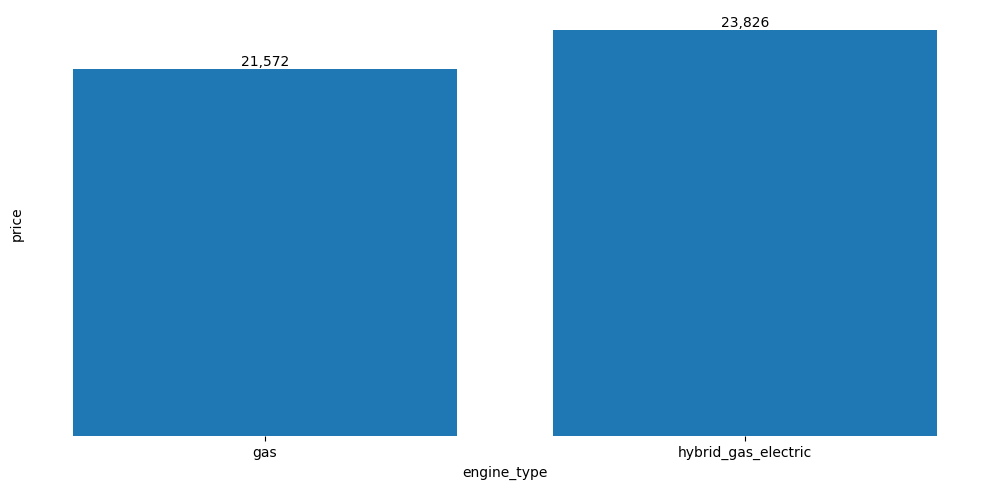

In [28]:
preco_medio_engine_type = dados.groupby('engine_type')['price'].mean().reset_index()
plot_bar(preco_medio_engine_type, 'engine_type', 'price')

Existe diferença entre modelos alimentados a gás e hibridos(eletrico ou a gás), sendo necessário manter essa coluna

#### Feature Engineer

Aplicando a técnica One Hot Encoder para as variáveis categórias

In [29]:
# aplicando o One Hot Enconder
encoder = OneHotEncoder(sparse_output=False)

# Ajustando e transformando os dados
encoded_features = encoder.fit_transform(dados[['brand', 'engine_type']])

# Convertendo para DataFrame
df_encoded_features = pd.DataFrame(encoded_features, columns=encoder.get_feature_names_out(['brand', 'engine_type']))

In [30]:
dados = pd.concat([dados, df_encoded_features], axis=1)

In [31]:
dados.dropna(inplace=True)

In [32]:
dados = dados[['rear_legroom', 'horsepower', 'torque',
       'year', 'price', 'brand_Chevrolet', 'brand_Ford', 'brand_Honda',
       'brand_Hyundai', 'brand_Subaru', 'brand_Volkswagen', 'engine_type_gas', 'engine_type_hybrid_gas_electric']]

In [33]:
dados.shape

(50, 13)

In [34]:
x = dados.drop('price', axis=1)
y = dados[['price']]

In [35]:
# selecionando dados de treino e teste
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, shuffle=True,  random_state=42)

Aplicando padronização dos dados, visto que temos escalas diferentes. ex: 'year' e 'rear_legroom'

In [36]:
scaler = StandardScaler()

scaler.fit(x)

StandardScaler()

In [37]:
x_train = scaler.transform(x_train)
x_test = scaler.transform(x_test)

#### Algoritmos de Regressão

##### Regressão Linear

Instanciando e aplicando o modelo

In [38]:
model_lr = LinearRegression()

model_lr.fit(x_train, y_train)

LinearRegression()

In [62]:
y_pred_lr = model_lr.predict(x_test)

Avaliando o modelo

In [65]:
mae_lr = mean_absolute_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)

print(f'MAE: {mae_lr}')
print(f'R2: {r2_lr}')

MAE: 2138.9339546133797
R2: -0.350447308907762


##### Random Forest

Instanciando e aplicando o modelo

In [61]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)

model_rf.fit(x_train, y_train)

c:\Users\Igor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RandomForestRegressor(random_state=42)

In [64]:
y_pred_rf = model_rf.predict(x_test)

Avaliando o modelo

In [66]:
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print(f'MAE: {mae_rf}')
print(f'R2: {r2_rf}')

MAE: 1851.0285666666653
R2: 0.16274270544533997


##### SVR

Instanciando o modelo

In [68]:
model_svr = SVR(kernel='linear')

model_svr.fit(x_train, y_train)

c:\Users\Igor\AppData\Local\Programs\Python\Python312\Lib\site-packages\sklearn\utils\validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(kernel='linear')

In [69]:
y_pred_svr = model_svr.predict(x_test)

Avaliando o modelo

In [70]:
mae_svr = mean_absolute_error(y_test, y_pred_svr)
r2_svr = r2_score(y_test, y_pred_svr)

print(f'MAE: {mae_svr}')
print(f'R2: {r2_svr}')

MAE: 2060.471367646288
R2: -0.06369708466176127


#### Conclusão 

Nenhum modelo performou bem, possivelmente pelo fato da base ter apenas 51 linhas.

Ideal é encontrar uma base maior para trabalhar.